## Get started by installing and importing dependencies, and reading in the CSV data.

In [285]:
%pip install prophet
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet

In [3]:
data_x = pd.read_csv("files/congress-trading-all.csv")
x_df = pd.DataFrame(data_x)
display(x_df.head())

,Ticker,TickerType,Company,Traded,Transaction,Trade_Size_USD,Status,Subholding,Description,Name,BioGuideID,Filed,Party,District,Chamber,Comments,Quiver_Upload_Time,excess_return,State,last_modified
0,GLW,ST,CORNING INCORPORATED COMMON STOCK,2024-07-23,Purchase,"$1,001 - $15,000",NEW,NaN,NaN,Marjorie Taylor Mrs Greene,G000596,2024-07-24,R,GA14,House,NaN,2024-07-25,-1.054504,Georgia,2024-07-25
1,ABCB,ST,AMERIS BANCORP - COMMON STOCK,2024-07-23,Sale,"$100,001 - $250,000",NEW,STIFEL,NaN,Earl Leroy Carter,C001103,2024-07-24,R,GA01,House,NaN,2024-07-25,2.772833,Georgia,2024-07-25
2,UPS,ST,"UNITED PARCEL SERVICE, INC. COMMON STOCK",2024-07-23,Purchase,"$1,001 - $15,000",NEW,NaN,NaN,Marjorie Taylor Mrs Greene,G000596,2024-07-24,R,GA14,House,NaN,2024-07-25,2.592441,Georgia,2024-07-25
3,DUK,ST,DUKE ENERGY CORPORATION,2024-07-23,Purchase,"$1,001 - $15,000",NEW,NaN,NaN,Marjorie Taylor Mrs Greene,G000596,2024-07-24,R,GA14,House,NaN,2024-07-25,2.541266,Georgia,2024-07-25
4,JPM,ST,JP MORGAN CHASE & CO. COMMON STOCK,2024-07-23,Purchase,"$1,001 - $15,000",NEW,NaN,NaN,Marjorie Taylor Mrs Greene,G000596,2024-07-24,R,GA14,House,NaN,2024-07-25,2.599848,Georgia,2024-07-25


## Clean and inspect the data

In [56]:
# Clean the data by keeping the needed columns
x_df_clean = x_df[['Name','Party', 'Company','Traded', 'Transaction', 'Trade_Size_USD', 'excess_return']]
x_df_clean['excess_return'] = x_df_clean['excess_return'].fillna(0).round(2)
x_df_clean['Trade_Size_USD'] = x_df_clean['Trade_Size_USD'].fillna(0).round(2)
x_df_clean['excess_return'] = x_df_clean['excess_return'].round(2)
x_df_clean['Traded'] = pd.to_datetime(x_df_clean['Traded'])
x_df_clean = x_df_clean[x_df_clean['Party'].isin(['D', 'R'])]
display(x_df_clean.head())
display(x_df_clean.tail())

/var/folders/k4/ds2_p0md3jn6b2dh7nt_yzth0000gn/T/ipykernel_30491/1179274596.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_clean['excess_return'] = x_df_clean['excess_return'].fillna(0).round(2)
/var/folders/k4/ds2_p0md3jn6b2dh7nt_yzth0000gn/T/ipykernel_30491/1179274596.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_clean['Trade_Size_USD'] = x_df_clean['Trade_Size_USD'].fillna(0).round(2)
/var/folders/k4/ds2_p0md3jn6b2dh7nt_yzth0000gn/T/ipykernel_30491/1179274596.py:5: SettingWithCopyWar

,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return
0,Marjorie Taylor Mrs Greene,R,CORNING INCORPORATED COMMON STOCK,2024-07-23,Purchase,"$1,001 - $15,000",-1.05
1,Earl Leroy Carter,R,AMERIS BANCORP - COMMON STOCK,2024-07-23,Sale,"$100,001 - $250,000",2.77
2,Marjorie Taylor Mrs Greene,R,"UNITED PARCEL SERVICE, INC. COMMON STOCK",2024-07-23,Purchase,"$1,001 - $15,000",2.59
3,Marjorie Taylor Mrs Greene,R,DUKE ENERGY CORPORATION,2024-07-23,Purchase,"$1,001 - $15,000",2.54
4,Marjorie Taylor Mrs Greene,R,JP MORGAN CHASE & CO. COMMON STOCK,2024-07-23,Purchase,"$1,001 - $15,000",2.60


,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return
47266,Ms. Tammy Duckworth,D,"CATERPILLAR, INC.",2012-07-26,Purchase,"$1,001 - $15,000",19.00
47267,Ms. Tammy Duckworth,D,PROCTER & GAMBLE COMPANY,2012-07-24,Sale,"$1,001 - $15,000",-143.88
47268,Mr. Alan S. Lowenthal,D,KANSAS CITY SOUTHERN,2012-06-06,Purchase,"$1,001 - $15,000",89.24
47269,Mr. Alan S. Lowenthal,D,EL PASO CORPORATION PREFERRED STOCK,2012-03-20,Sale,"$1,001 - $15,000",0.00
47270,Mr. Alan S. Lowenthal,D,EL PASO CORPORATION PREFERRED STOCK,2012-02-27,Sale,"$1,001 - $15,000",0.00


In [57]:
# Create a new column for 'Name_Party'
x_df_clean['Name_Party'] = x_df_clean['Name'] + ' (' + x_df_clean['Party'] + ')'
x_df_clean2 = x_df_clean[['Name_Party', 'Party', 'Company', 'Traded', 'Transaction', 'Trade_Size_USD', 'excess_return']]
x_df_clean2.head()

,Name_Party,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return
0,Marjorie Taylor Mrs Greene (R),R,CORNING INCORPORATED COMMON STOCK,2024-07-23,Purchase,"$1,001 - $15,000",-1.05
1,Earl Leroy Carter (R),R,AMERIS BANCORP - COMMON STOCK,2024-07-23,Sale,"$100,001 - $250,000",2.77
2,Marjorie Taylor Mrs Greene (R),R,"UNITED PARCEL SERVICE, INC. COMMON STOCK",2024-07-23,Purchase,"$1,001 - $15,000",2.59
3,Marjorie Taylor Mrs Greene (R),R,DUKE ENERGY CORPORATION,2024-07-23,Purchase,"$1,001 - $15,000",2.54
4,Marjorie Taylor Mrs Greene (R),R,JP MORGAN CHASE & CO. COMMON STOCK,2024-07-23,Purchase,"$1,001 - $15,000",2.60


## Find the politicians who had the most trades

In [58]:
top_subjects = x_df_clean2['Name_Party'].value_counts().head(6)
top_subjects

Name_Party
Josh Gottheimer (D)     2786
Thomas Macarthur (R)    2758
Perdue, David (R)       2242
Lois Frankel (D)        1358
Greg Gianforte (R)      1331
Susie Lee (D)           1262
Name: count, dtype: int64

## Create a new dataframe with the top 6 politicians with the most trades across all years

In [59]:
df_josh = x_df_clean[x_df_clean['Name_Party'] == 'Josh Gottheimer (D)']
df_thomas = x_df_clean[x_df_clean['Name_Party'] == 'Thomas Macarthur (R)']
df_perdue = x_df_clean[x_df_clean['Name_Party'] == 'Perdue, David (R)']
df_lois = x_df_clean[x_df_clean['Name_Party'] == 'Lois Frankel (D)']
df_greg = x_df_clean[x_df_clean['Name_Party'] == 'Greg Gianforte (R)']
df_susie = x_df_clean[x_df_clean['Name_Party'] == 'Susie Lee (D)']

top6_traded_df = pd.concat([
    df_josh,
    df_thomas,
    df_perdue,
    df_lois,
    df_greg,
    df_susie
], ignore_index=True)
top6_traded_df

,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party
0,Josh Gottheimer,D,MARRIOTT INTERNATIONAL - CLASS A COMMON STOCK,2024-06-28,Sale,"$1,001 - $15,000",-2.18,Josh Gottheimer (D)
1,Josh Gottheimer,D,APPLE INC. - COMMON STOCK,2024-06-28,Purchase,"$1,001 - $15,000",3.44,Josh Gottheimer (D)
2,Josh Gottheimer,D,NVIDIA CORPORATION - COMMON STOCK,2024-06-28,Purchase,"$1,001 - $15,000",-8.52,Josh Gottheimer (D)
3,Josh Gottheimer,D,MICROSOFT CORPORATION - COMMON STOCK,2024-06-28,Purchase,"$1,001 - $15,000",-4.89,Josh Gottheimer (D)
4,Josh Gottheimer,D,"LOWE'S COMPANIES, INC. COMMON STOCK",2024-06-28,Sale,"$1,001 - $15,000",8.31,Josh Gottheimer (D)
...,...,...,...,...,...,...,...,...
11732,Susie Lee,D,DELL TECHNOLOGIES INC. CLASS C,2019-01-14,Purchase,"$1,001 - $15,000",53.84,Susie Lee (D)
11733,Susie Lee,D,BP P.L.C.,2019-01-11,Sale,"$15,001 - $50,000",-119.94,Susie Lee (D)
11734,Susie Lee,D,GREAT CANADIAN GAMING CORP ORDINARY SHARES,2019-01-11,Sale,"$1,001 - $15,000",0.00,Susie Lee (D)
11735,Susie Lee,D,GREAT CANADIAN GAMING CORP ORDINARY SHARES,2019-01-11,Sale,"$1,001 - $15,000",0.00,Susie Lee (D)


## Create a new dataframe with the top 6 politicians with the most trades from 2019-2021

In [60]:
top6_traded_19_21 = top6_traded_df[(top6_traded_df['Traded'] >= '2019-01-01') & (top6_traded_df['Traded'] <= '2021-12-31')]
top6_traded_19_21

,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party
1265,Josh Gottheimer,D,"META PLATFORMS, INC. - CLASS A",2021-12-29,Sale,"$1,001 - $15,000",-28.76,Josh Gottheimer (D)
1266,Josh Gottheimer,D,PING AN INSURANCE,2021-12-28,Sale,"$1,001 - $15,000",-53.92,Josh Gottheimer (D)
1267,Josh Gottheimer,D,"AFFIRM HOLDINGS, INC. - CLASS A",2021-12-28,Sale,"$1,001 - $15,000",-87.48,Josh Gottheimer (D)
1268,Josh Gottheimer,D,TENCENT HOLDINGS LIMITED UNSPONSORED ADR REPRE...,2021-12-28,Sale,"$1,001 - $15,000",-35.96,Josh Gottheimer (D)
1269,Josh Gottheimer,D,XP INC. - CLASS A,2021-12-22,Purchase,"$1,001 - $15,000",-56.30,Josh Gottheimer (D)
...,...,...,...,...,...,...,...,...
11732,Susie Lee,D,DELL TECHNOLOGIES INC. CLASS C,2019-01-14,Purchase,"$1,001 - $15,000",53.84,Susie Lee (D)
11733,Susie Lee,D,BP P.L.C.,2019-01-11,Sale,"$15,001 - $50,000",-119.94,Susie Lee (D)
11734,Susie Lee,D,GREAT CANADIAN GAMING CORP ORDINARY SHARES,2019-01-11,Sale,"$1,001 - $15,000",0.00,Susie Lee (D)
11735,Susie Lee,D,GREAT CANADIAN GAMING CORP ORDINARY SHARES,2019-01-11,Sale,"$1,001 - $15,000",0.00,Susie Lee (D)


In [61]:
josh_fil = top6_traded_19_21[top6_traded_19_21['Name_Party'] == 'Josh Gottheimer (D)']
thomas_fil = top6_traded_19_21[top6_traded_19_21['Name_Party'] == 'Thomas Macarthur (R)']
perdue_fil = top6_traded_19_21[top6_traded_19_21['Name_Party'] == 'Perdue, David (R)']
lois_fil = top6_traded_19_21[top6_traded_19_21['Name_Party'] == 'Lois Frankel (D)']
greg_fil = top6_traded_19_21[top6_traded_19_21['Name_Party'] == 'Greg Gianforte (R)']
susie_fil = top6_traded_19_21[top6_traded_19_21['Name_Party'] == 'Susie Lee (D)']

## Plot the trades of each politician from 2019-2021

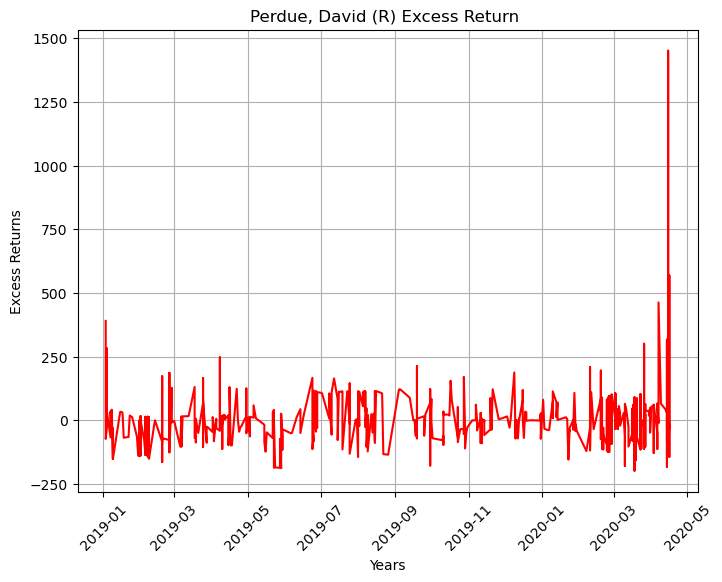

In [62]:
plt.figure(figsize=(8,6))
plt.plot(perdue_fil['Traded'], perdue_fil['excess_return'], color='r')
plt.grid(True)
plt.xlabel('Years')
plt.ylabel('Excess Returns')
plt.title("Perdue, David (R) Excess Return ")
plt.xticks(rotation=45)
plt.show()

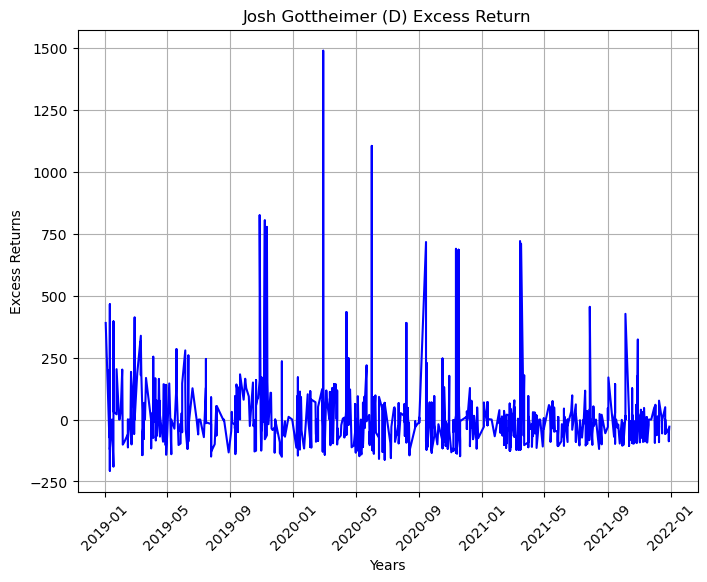

In [63]:
plt.figure(figsize=(8,6))
plt.plot(josh_fil['Traded'], josh_fil['excess_return'], color= 'b')
plt.grid(True)
plt.xlabel('Years')
plt.ylabel('Excess Returns')
plt.title("Josh Gottheimer (D) Excess Return")
plt.xticks(rotation=45)
plt.show()

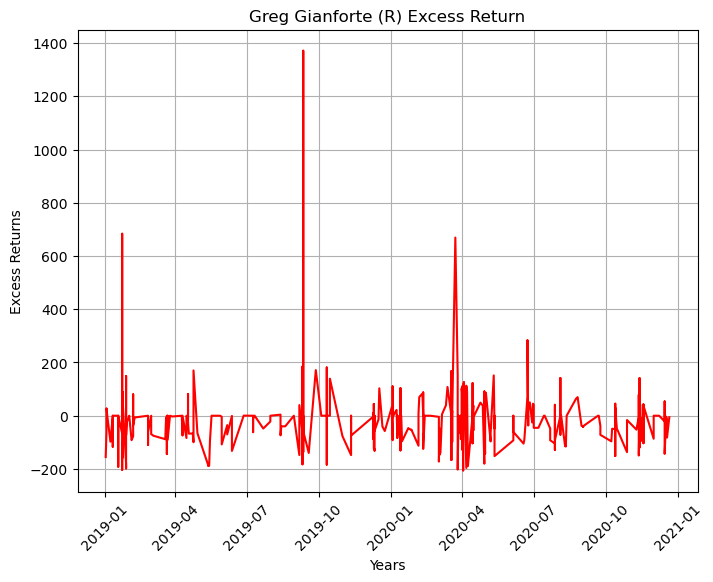

In [12]:
plt.figure(figsize=(8,6))
plt.plot(greg_fil['Traded'], greg_fil['excess_return'], color= 'r')
plt.grid(True)
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Excess Returns')
plt.title("Greg Gianforte (R) Excess Return")
plt.show()

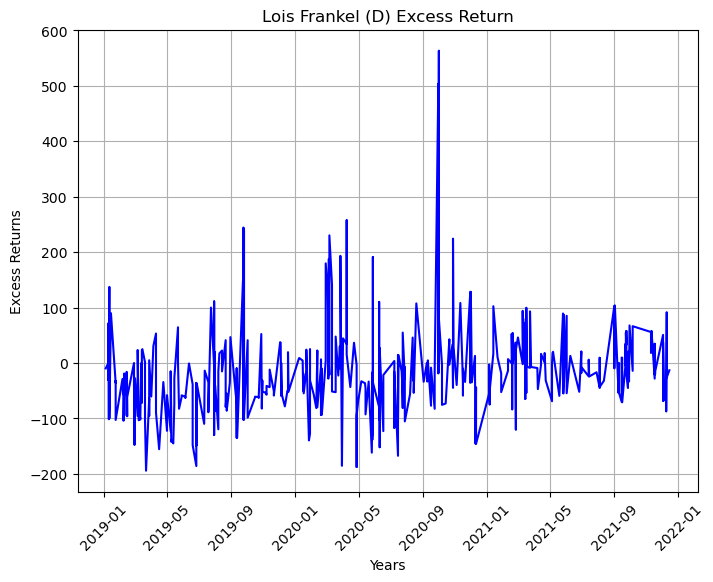

In [13]:
plt.figure(figsize=(8,6))
plt.plot(lois_fil['Traded'], lois_fil['excess_return'], color= 'b')
plt.grid(True)
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Excess Returns')
plt.title("Lois Frankel (D) Excess Return")
plt.show()

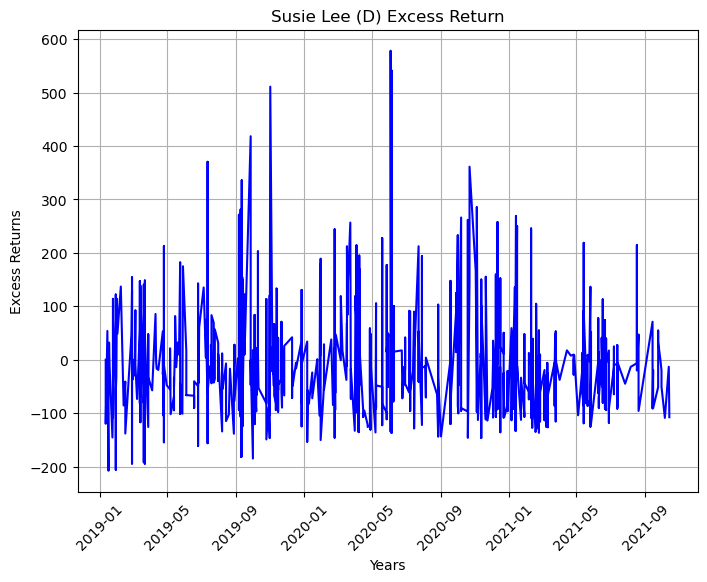

In [14]:
plt.figure(figsize=(8,6))
plt.plot(susie_fil['Traded'], susie_fil['excess_return'], color= 'b')
plt.grid(True)
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Excess Returns')
plt.title("Susie Lee (D) Excess Return")
plt.show()

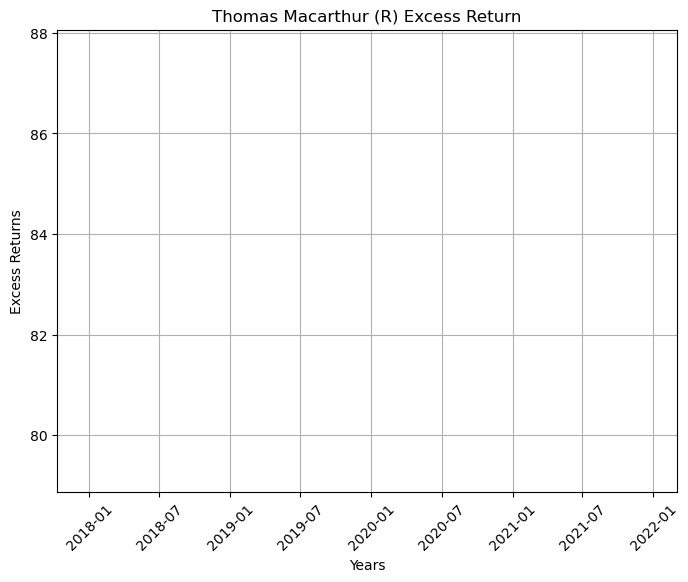

In [15]:
plt.figure(figsize=(8,6))
plt.plot(thomas_fil['Traded'], thomas_fil['excess_return'], color= 'r')
plt.grid(True)
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Excess Returns')
plt.title("Thomas Macarthur (R) Excess Return")
plt.show()

## Display the dataframe for each top republican traders

In [64]:
display(perdue_fil)
display(greg_fil)
display(thomas_fil)

,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party
5544,"Perdue, David",R,The Southern Company JR SUB NT 2015A,2020-04-16,Sale (Full),"$15,001 - $50,000",-25.49,"Perdue, David (R)"
5545,"Perdue, David",R,Philip Morris International Inc.,2020-04-16,Sale (Full),"$1,001 - $15,000",-44.67,"Perdue, David (R)"
5546,"Perdue, David",R,The Walt Disney Company,2020-04-16,Sale (Full),"$1,001 - $15,000",-106.89,"Perdue, David (R)"
5547,"Perdue, David",R,"General Mills, Inc.",2020-04-16,Sale (Full),"$1,001 - $15,000",-85.76,"Perdue, David (R)"
5548,"Perdue, David",R,ConocoPhillips,2020-04-16,Sale (Full),"$1,001 - $15,000",161.77,"Perdue, David (R)"
...,...,...,...,...,...,...,...,...
6367,"Perdue, David",R,Devon Energy Corporation,2019-01-04,Purchase,"$15,001 - $50,000",-27.14,"Perdue, David (R)"
6368,"Perdue, David",R,Knowles Corporation,2019-01-03,Sale (Partial),"$1,001 - $15,000",-72.94,"Perdue, David (R)"
6369,"Perdue, David",R,"BWX Technologies, Inc.",2019-01-03,Purchase,"$1,001 - $15,000",37.35,"Perdue, David (R)"
6370,"Perdue, David",R,"WPX Energy, Inc.",2019-01-03,Purchase,"$1,001 - $15,000",-71.22,"Perdue, David (R)"


,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party
9144,Greg Gianforte,R,CHINA MOBILE LIMITED,2020-12-21,Sale,"$100,001 - $250,000",-5.53,Greg Gianforte (R)
9145,Greg Gianforte,R,"VIASAT, INC.",2020-12-18,Purchase,"$100,001 - $250,000",-82.09,Greg Gianforte (R)
9146,Greg Gianforte,R,ISHARES RUSSELL 2000 VALUE ETF,2020-12-18,Sale,"$250,001 - $500,000",-15.49,Greg Gianforte (R)
9147,Greg Gianforte,R,CARDTRONICS PLC,2020-12-17,Sale,"$1,001 - $15,000",-3.60,Greg Gianforte (R)
9148,Greg Gianforte,R,CARDTRONICS PLC,2020-12-17,Sale,"$1,001 - $15,000",-3.60,Greg Gianforte (R)
...,...,...,...,...,...,...,...,...
9910,Greg Gianforte,R,ATLAS COPCO AB SPONSORED ADR REPSTG CLASS A,2019-01-04,Purchase,"$100,001 - $250,000",0.00,Greg Gianforte (R)
9911,Greg Gianforte,R,INFINEON TECHNOLOGIES AG,2019-01-04,Purchase,"$250,001 - $500,000",0.00,Greg Gianforte (R)
9912,Greg Gianforte,R,MULTI-COLOR CORPORATION,2019-01-03,Purchase,"$100,001 - $250,000",27.97,Greg Gianforte (R)
9913,Greg Gianforte,R,"THERMON GROUP HOLDINGS, INC.",2019-01-03,Purchase,"$50,001 - $100,000",-60.96,Greg Gianforte (R)


,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party
2786,Thomas Macarthur,R,"INTERACTIVE BROKERS GROUP, INC.",2019-12-21,Purchase,"$1,001 - $15,000",83.47,Thomas Macarthur (R)


## Display the dataframe for each top democrat traders

In [65]:
display(josh_fil)
display(lois_fil)
display(susie_fil)

,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party
1265,Josh Gottheimer,D,"META PLATFORMS, INC. - CLASS A",2021-12-29,Sale,"$1,001 - $15,000",-28.76,Josh Gottheimer (D)
1266,Josh Gottheimer,D,PING AN INSURANCE,2021-12-28,Sale,"$1,001 - $15,000",-53.92,Josh Gottheimer (D)
1267,Josh Gottheimer,D,"AFFIRM HOLDINGS, INC. - CLASS A",2021-12-28,Sale,"$1,001 - $15,000",-87.48,Josh Gottheimer (D)
1268,Josh Gottheimer,D,TENCENT HOLDINGS LIMITED UNSPONSORED ADR REPRE...,2021-12-28,Sale,"$1,001 - $15,000",-35.96,Josh Gottheimer (D)
1269,Josh Gottheimer,D,XP INC. - CLASS A,2021-12-22,Purchase,"$1,001 - $15,000",-56.30,Josh Gottheimer (D)
...,...,...,...,...,...,...,...,...
2439,Josh Gottheimer,D,"ALTRIA GROUP, INC.",2019-01-11,Purchase,"$1,001 - $15,000",-107.19,Josh Gottheimer (D)
2440,Josh Gottheimer,D,"UNITED PARCEL SERVICE, INC.",2019-01-11,Purchase,"$1,001 - $15,000",-78.74,Josh Gottheimer (D)
2441,Josh Gottheimer,D,MICROSOFT CORPORATION,2019-01-10,Sale,"$1,001 - $15,000",200.27,Josh Gottheimer (D)
2442,Josh Gottheimer,D,NEWMARKET CORP,2019-01-10,Sale,"$1,001 - $15,000",-71.84,Josh Gottheimer (D)


,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party
8154,Lois Frankel,D,KIMBERLY-CLARK CORPORATION,2021-12-15,Sale,"$1,001 - $15,000",-13.08,Lois Frankel (D)
8155,Lois Frankel,D,"ZIMMER BIOMET HOLDINGS, INC.",2021-12-10,Purchase,"$1,001 - $15,000",-26.19,Lois Frankel (D)
8156,Lois Frankel,D,"INSPERITY, INC.",2021-12-10,Purchase,"$1,001 - $15,000",-24.84,Lois Frankel (D)
8157,Lois Frankel,D,"BWX TECHNOLOGIES, INC.",2021-12-10,Purchase,"$1,001 - $15,000",91.69,Lois Frankel (D)
8158,Lois Frankel,D,"EPAM SYSTEMS, INC.",2021-12-09,Sale,"$1,001 - $15,000",-86.54,Lois Frankel (D)
...,...,...,...,...,...,...,...,...
8585,Lois Frankel,D,HUNTSMAN CORPORATION,2019-01-10,Purchase,"$1,001 - $15,000",-101.49,Lois Frankel (D)
8586,Lois Frankel,D,"GOLDMAN SACHS GROUP, INC.",2019-01-09,Sale,"$1,001 - $15,000",71.68,Lois Frankel (D)
8587,Lois Frankel,D,"EXPEDITORS INTERNATIONAL OF WASHINGTON, INC.",2019-01-09,Purchase,"$1,001 - $15,000",-30.26,Lois Frankel (D)
8588,Lois Frankel,D,ROCHE HOLDINGS AG BASEL AMERICAN DEPOSITARY SH...,2019-01-09,Purchase,"$1,001 - $15,000",0.00,Lois Frankel (D)


,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party
10557,Susie Lee,D,"RACKSPACE TECHNOLOGY, INC.",2021-10-14,Sale,"$1,001 - $15,000",-107.67,Susie Lee (D)
10558,Susie Lee,D,HOWARD HUGHES CORPORATION,2021-10-13,Sale,"$1,001 - $15,000",-13.26,Susie Lee (D)
10559,Susie Lee,D,"COMMSCOPE HOLDING COMPANY, INC.",2021-10-06,Sale,"$1,001 - $15,000",-108.93,Susie Lee (D)
10560,Susie Lee,D,"ZIMMER BIOMET HOLDINGS, INC.",2021-09-30,Sale,"$15,001 - $50,000",-50.82,Susie Lee (D)
10561,Susie Lee,D,SYNCHRONY FINANCIAL,2021-09-30,Sale,"$1,001 - $15,000",-22.97,Susie Lee (D)
...,...,...,...,...,...,...,...,...
11732,Susie Lee,D,DELL TECHNOLOGIES INC. CLASS C,2019-01-14,Purchase,"$1,001 - $15,000",53.84,Susie Lee (D)
11733,Susie Lee,D,BP P.L.C.,2019-01-11,Sale,"$15,001 - $50,000",-119.94,Susie Lee (D)
11734,Susie Lee,D,GREAT CANADIAN GAMING CORP ORDINARY SHARES,2019-01-11,Sale,"$1,001 - $15,000",0.00,Susie Lee (D)
11735,Susie Lee,D,GREAT CANADIAN GAMING CORP ORDINARY SHARES,2019-01-11,Sale,"$1,001 - $15,000",0.00,Susie Lee (D)


## Display the top traded companies for each Republican

In [66]:
perdue_name = perdue_fil['Name_Party'].iloc[0]
counts = perdue_fil['Company'].value_counts().head(1)
company_name = counts.index[0]
count = counts.values[0]
print(f"{perdue_name} had {count} trades for {company_name}")

greg_name = greg_fil['Name_Party'].iloc[0]
counts = greg_fil['Company'].value_counts().head(1)
company_name = counts.index[0]
count = counts.values[0]
print(f"{greg_name} had {count} trades for {company_name}")

thomas_name = thomas_fil['Name_Party'].iloc[0]
counts = thomas_fil['Company'].value_counts().head(1)
company_name = counts.index[0]
count = counts.values[0]
print(f"{thomas_name} had {count} trades for {company_name}")

Perdue, David (R) had 33 trades for Caesars Entertainment Corporation
Greg Gianforte (R) had 15 trades for AMN HEALTHCARE SERVICES INC AMN HEALTHCARE SERVICES INC
Thomas Macarthur (R) had 1 trades for INTERACTIVE BROKERS GROUP, INC.


**Most Common Company of Stocks Purchased from 2019-2021-- Republicans**

*Perdue- Caesar's Entertainment Corporation- 33 Total*

*Greg- AMN Healthcare Services Inc.- 15 Total*

*Thomas- Interactive Brokers Group, Inc.- 1 Total*


## Display the top traded companies for each Democrat

In [67]:
josh_name = josh_fil['Name_Party'].iloc[0]
counts = josh_fil['Company'].value_counts().head(1)
company_name = counts.index[0]
count = counts.values[0]
print(f"{josh_name} had {count} trades for {company_name}")

lois_name = lois_fil['Name_Party'].iloc[0]
counts = lois_fil['Company'].value_counts().head(1)
company_name = counts.index[0]
count = counts.values[0]
print(f"{lois_name} had {count} trades for {company_name}")

susie_name = susie_fil['Name_Party'].iloc[0]
counts = susie_fil['Company'].value_counts().head(1)
company_name = counts.index[0]
count = counts.values[0]
print(f"{susie_name} had {count} trades for {company_name}")

Josh Gottheimer (D) had 156 trades for MICROSOFT CORPORATION
Lois Frankel (D) had 10 trades for DUPONT DE NEMOURS, INC.
Susie Lee (D) had 21 trades for BALL CORPORATION


**Most Common Company of Stocks Purchased from 2019-2021-- Democrats**

*Josh- Microsoft Corporation- 156 Total*

*Lois- Dupont De Nemours, Inc. - 10 Total*

*Susie- Ball Corporation - 21 Total*

## Average Excess Return from Priorly Determined Companies from 2019-2021--Republicans

In [68]:
perdue__comp = perdue_fil[perdue_fil['Company'] == 'Caesars Entertainment Corporation']
cec_avg =perdue__comp['excess_return'].mean().round(2)
print(f"The average excess return for Perdue from Caesars Entertainment Corp is {cec_avg} from 2019-2021.")


The average excess return for Perdue from Caesars Entertainment Corp is 109.63 from 2019-2021.


In [69]:
greg__comp = greg_fil[greg_fil['Company'] == 'AMN HEALTHCARE SERVICES INC AMN HEALTHCARE SERVICES INC']
amn_avg =greg__comp['excess_return'].mean().round(2)
print(f"The average excess return for Greg from AMN Healthcare Services is {amn_avg} from 2019-2021.")

The average excess return for Greg from AMN Healthcare Services is -48.22 from 2019-2021.


In [70]:
thomas__comp = thomas_fil[thomas_fil['Company'] == 'INTERACTIVE BROKERS GROUP, INC.']
ibg_avg =thomas__comp['excess_return'].mean().round(2)
print(f"The average excess return for Thomas from Interactive Brokers Group is {ibg_avg} from 2019-2021.")

The average excess return for Thomas from Interactive Brokers Group is 83.47 from 2019-2021.


In [71]:
repub_19_21 = {
    "Republican": ['Perdue', 'Greg', 'Thomas'],
    "Average Excess Return 2019-2021": [cec_avg, amn_avg, ibg_avg],
}

repub_19_21_df = pd.DataFrame(repub_19_21)
repub_19_21_df

,Republican,Average Excess Return 2019-2021
0,Perdue,109.63
1,Greg,-48.22
2,Thomas,83.47


(array([0, 1, 2]),
 [Text(0, 0, 'Perdue'), Text(1, 0, 'Greg'), Text(2, 0, 'Thomas')])

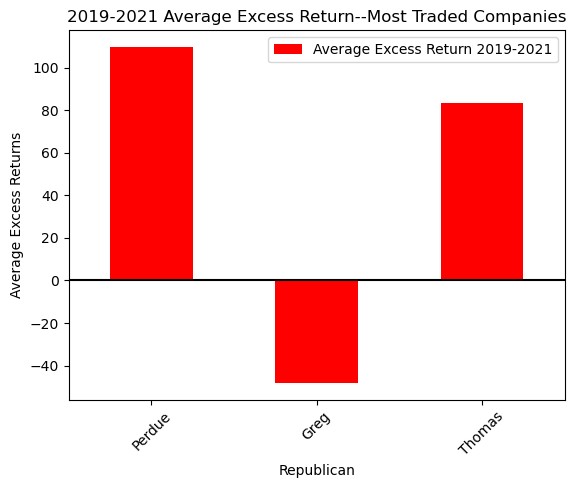

In [72]:
repub_19_21_df.plot.bar(x='Republican', y="Average Excess Return 2019-2021", color="r")
plt.axhline(0, color='black', linestyle='-')
plt.ylabel('Average Excess Returns')
plt.title('2019-2021 Average Excess Return--Most Traded Companies')
plt.xticks(rotation=45)

## Average Excess Return for Prior Mentioned Companies from 2019-2021--Democrats**

In [73]:
josh__comp = josh_fil[josh_fil['Company'] == 'MICROSOFT CORPORATION']
mc_avg =josh__comp['excess_return'].mean().round(2)
print(f"The average excess return for Josh from Microsoft Corporation is {mc_avg} from 2019-2021.")

The average excess return for Josh from Microsoft Corporation is 84.84 from 2019-2021.


In [74]:
lois__comp = lois_fil[lois_fil['Company'] == 'DUPONT DE NEMOURS, INC.']
ddn_avg =lois__comp['excess_return'].mean().round(2)
print(f"The average excess return for Lois from Dupont De Nemours, Inc. is {ddn_avg} from 2019-2021.")

The average excess return for Lois from Dupont De Nemours, Inc. is -27.15 from 2019-2021.


In [27]:
susie__comp = susie_fil[susie_fil['Company'] == 'BALL CORPORATION']
bc_avg =susie__comp['excess_return'].mean().round(2)
print(f"The average excess return for Susie from Ball Corporation is {bc_avg} from 2019-2021.")

The average excess return for Susie from Ball Corporation is -23.38 from 2019-2021.


In [28]:
democrat_19_21 = {
    "Democrat": ['Josh', 'Lois', 'Susie'],
    "Average Excess Return 2019-2021": [mc_avg, ddn_avg, bc_avg],
}

democrat_19_21_df = pd.DataFrame(democrat_19_21)
democrat_19_21_df

,Democrat,Average Excess Return 2019-2021
0,Josh,84.84
1,Lois,-27.15
2,Susie,-23.38


(array([0, 1, 2]),
 [Text(0, 0, 'Josh'), Text(1, 0, 'Lois'), Text(2, 0, 'Susie')])

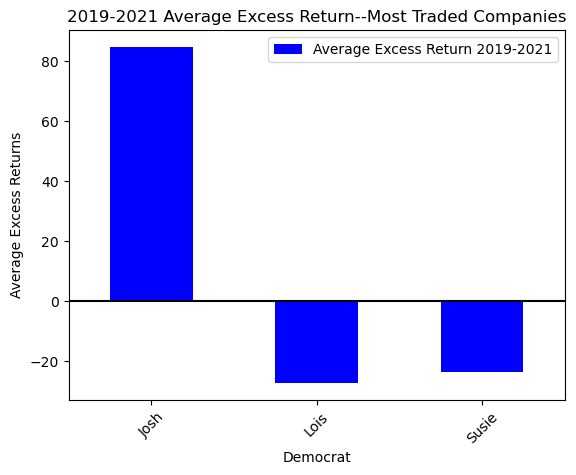

In [29]:
democrat_19_21_df.plot.bar(x='Democrat', y="Average Excess Return 2019-2021", color="b")
plt.axhline(0, color='black', linestyle='-')
plt.ylabel('Average Excess Returns')
plt.title('2019-2021 Average Excess Return--Most Traded Companies')
plt.xticks(rotation=45)

## Average Excess Returns in 2019-2021 (all companies accounted for)

In [30]:
perdue_exc_avg = perdue_fil['excess_return'].mean().round(2)
greg_exc_avg = greg_fil['excess_return'].mean().round(2)
thomas_exc_avg = thomas_fil['excess_return'].mean().round(2)

rep_exc_avg = {
    'Republican': ['Perdue', 'Greg', 'Thomas'],
    'Excess Return Average': [perdue_exc_avg, greg_exc_avg, thomas_exc_avg],
}

rep_excavg_df = pd.DataFrame(rep_exc_avg)
rep_excavg_df

,Republican,Excess Return Average
0,Perdue,-6.54
1,Greg,-16.95
2,Thomas,83.47


(array([0, 1, 2]),
 [Text(0, 0, 'Perdue'), Text(1, 0, 'Greg'), Text(2, 0, 'Thomas')])

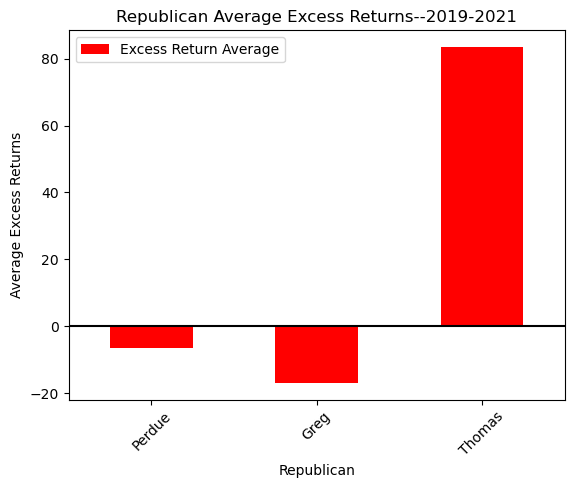

In [31]:
rep_excavg_df.plot.bar(x='Republican', y="Excess Return Average", color="r")
plt.axhline(0, color='black', linestyle='-')
plt.ylabel('Average Excess Returns')
plt.title('Republican Average Excess Returns--2019-2021')
plt.xticks(rotation=45)

In [32]:
josh_exc_avg = josh_fil['excess_return'].mean().round(2)
lois_exc_avg = lois_fil['excess_return'].mean().round(2)
susie_exc_avg = susie_fil['excess_return'].mean().round(2)

dem_exc_avg = {
    'Democrat': ['Josh', 'Lois', 'Susie'],
    'Excess Return Average': [josh_exc_avg, lois_exc_avg, susie_exc_avg],
}

dem_excavg_df = pd.DataFrame(dem_exc_avg)
dem_excavg_df

,Democrat,Excess Return Average
0,Josh,5.27
1,Lois,-19.12
2,Susie,-16.99


(array([0, 1, 2]),
 [Text(0, 0, 'Josh'), Text(1, 0, 'Lois'), Text(2, 0, 'Susie')])

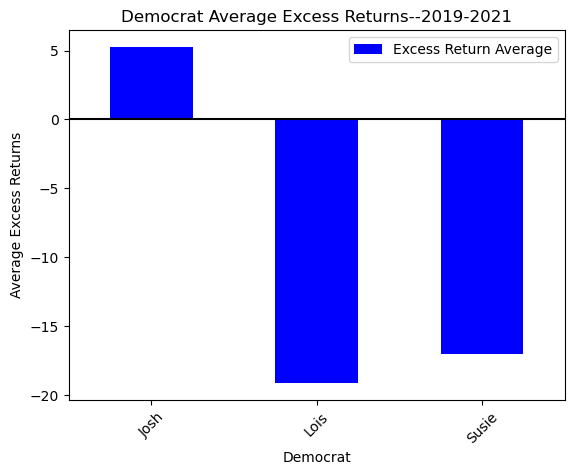

In [33]:
dem_excavg_df.plot.bar(x='Democrat', y="Excess Return Average", color="b")
plt.axhline(0, color='black', linestyle='-')
plt.ylabel('Average Excess Returns')
plt.title('Democrat Average Excess Returns--2019-2021')
plt.xticks(rotation=45)

## Is there a difference in excess return based on the party of politician?

This section aims to identify the excess return of each party, the highest performing politician,
the excess return from 2019-2021, and the highest performing politician from 2019-2021.

The goal is to identify if there is in party performance, or a trend in the performance of an individual
that is worth making similar investments for someone outside of politics.

### Create a dataframe based on the top 6 politicians who had the highest excess return

In [75]:
# Filter Republicans and Democrats
republicans = x_df_clean2[x_df_clean2['Party'] == 'R']
democrats = x_df_clean2[x_df_clean2['Party'] == 'D']

# Group by Name_Party and sum the excess_return
republican_sums = republicans.groupby('Name_Party')['excess_return'].sum().reset_index()
democrat_sums = democrats.groupby('Name_Party')['excess_return'].sum().reset_index()

# Sort and get top 3
top_republicans = republican_sums.sort_values(by='excess_return', ascending=False).head(3)
top_democrats = democrat_sums.sort_values(by='excess_return', ascending=False).head(3)

# Combine the top Republicans and Democrats
top_politicians = pd.concat([top_republicans, top_democrats])
top_politicians = top_politicians.rename(columns={'excess_return': 'total_excess_return'})

# Merge with original DataFrame to get all columns
top_politicians_df = pd.merge(x_df_clean2, top_politicians, on='Name_Party', how='inner')
display(top_politicians_df)

,Name_Party,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,total_excess_return
0,"Whitehouse, Sheldon (D)",D,"Goldman Sachs Group, Inc. (The) Common Stock",2024-06-27,Purchase,"$1,001 - $15,000",12.60,63956.88
1,"Whitehouse, Sheldon (D)",D,Home Depot,2024-06-13,Purchase,"$1,001 - $15,000",2.99,63956.88
2,"Whitehouse, Sheldon (D)",D,Microsoft Corp,2024-06-13,Purchase,"$1,001 - $15,000",-4.04,63956.88
3,Debbie Wasserman Schultz (D),D,PERION NETWORK LTD - ORDINARY SHARES,2024-05-16,Purchase,"$1,001 - $15,000",-32.91,64404.63
4,"Whitehouse, Sheldon (D)",D,Crown Castle Inc,2024-05-10,Purchase,"$1,001 - $15,000",3.54,63956.88
...,...,...,...,...,...,...,...,...
2269,"Whitehouse, Sheldon (D)",D,Altria Group Inc. (NYSE),2014-01-31,Purchase,"$1,001 - $15,000",-163.43,63956.88
2270,"Whitehouse, Sheldon (D)",D,The Clorox Company (NYSE),2014-01-31,Sale (Full),"$15,001 - $50,000",-154.11,63956.88
2271,"Whitehouse, Sheldon (D)",D,LinkedIn Corporation (NYSE),2014-01-29,Purchase,"$1,001 - $15,000",-30.99,63956.88
2272,"Whitehouse, Sheldon (D)",D,Symantec Corporation (NASDAQ),2014-01-29,Sale (Full),"$15,001 - $50,000",-75.52,63956.88


### Print the sum of all excess returns for each party across all years

In [76]:
print(f"Republican excess return for all years {republicans['excess_return'].sum():,.2f}")
print(f"Democrat excess return for all years {democrats['excess_return'].sum():,.2f}")

Republican excess return for all years -548,337.29
Democrat excess return for all years -123,073.97


### Print the excess return of the top performing politicians for each party for all years

In [77]:
grouped_excess_return = top_politicians_df.groupby('Party')['excess_return'].sum()
for party, excess_return in grouped_excess_return.items():
    print(f"Party: {party}, Excess Return: {excess_return:,.2f}")

Party: D, Excess Return: 151,888.77
Party: R, Excess Return: 77,908.50


In [78]:
excess_return_sum = top_politicians_df.groupby('Name_Party')['excess_return'].sum()
excess_return_sum

Name_Party
Debbie Wasserman Schultz (D)    64404.63
Mark Green (R)                  18811.46
Roberts, Pat (R)                46277.25
Roger W. Marshall (R)           12819.79
Thomas Suozzi (D)               23527.26
Whitehouse, Sheldon (D)         63956.88
Name: excess_return, dtype: float64

### Politician with the highest excess return across all years

In [79]:
person = excess_return_sum.idxmax()
highest_sum = excess_return_sum.max()
print(f"{person} had the highest excess return of {highest_sum:,.2f} for all years")

Debbie Wasserman Schultz (D) had the highest excess return of 64,404.63 for all years


### Excess return for each party from 2019-2021

In [80]:
excess_all_19_21 = x_df_clean2[(x_df_clean2['Traded'] >= '2019-01-01') & (x_df_clean2['Traded'] <= '2021-12-31')]
excess_grouped_19_21 = excess_all_19_21.groupby('Party')['excess_return'].sum()
for party, excess_return in excess_grouped_19_21.items():
    print(f"Party: {party}, Excess Return for 2019-2021: {excess_return:,.2f}")

Party: D, Excess Return for 2019-2021: -83,601.10
Party: R, Excess Return for 2019-2021: -45,513.04


### Excess return of the best performing politicians from each party from 2019-2021

In [81]:
combined_19_21 = top_politicians_df[(top_politicians_df['Traded'].dt.year >= 2019) & (top_politicians_df['Traded'].dt.year <= 2021)]
combined_19_21_group = combined_19_21.groupby('Party')['excess_return'].sum()
for party, excess_return in combined_19_21_group.items():
    print(f"Party: {party}, Excess Return for 2019-2021: {excess_return:,.2f}")

Party: D, Excess Return for 2019-2021: 30,051.73
Party: R, Excess Return for 2019-2021: 35,392.47


### Politician with the highest excess return from 2019-2021

In [82]:
top_politicians_df_19_21 = top_politicians_df[(top_politicians_df['Traded'] >= '2019-01-01') & (top_politicians_df['Traded'] <= '2021-12-31')]
grouped_19_21 = top_politicians_df_19_21.groupby('Name_Party')['excess_return'].sum()
person_19_21 = grouped_19_21.idxmax()
highest_sum_19_21 = grouped_19_21.max()

print(f"{person_19_21} had the highest excess return of {highest_sum_19_21:,.2f} from 2019 - 2021")

Thomas Suozzi (D) had the highest excess return of 27,117.85 from 2019 - 2021


**Question:** Which party had the highest excess return overall, not considering the top performing politicians?

**Answer:** The excess return of both parties, not considering the top performing politicians was negative.
The Republican excess return for all years was -569,214.59, and the Democrat excess return for all years was -211,929.01.

**Question:** Which party had the highest excess return for all years for the top performing politicians?

**Answer:** Both parties had a positive excess return. The Democrats had a higher return than the Republicans.
The excess return for the Democrats was 151,888.77, while the excess return for the Republicans was 77,908.50.
The Democrats excess return is 48.71% higher that of the Republicans.

**Question:** Which party had the highest excess return from 2019-2021?

**Answer:** When comparing the excess return by party from 2019-2021 the excess return was a lot closer.
Both parties were positive. The excess return for the Republicans was 35,392.47. The Democrats excess return was 30,051.73.
The Republicans' excess return is 17.80% higher that of the Democrats.

**Question:** Which politician performed the best across all years?

**Answer:** Debbie Wasserman Schultz (D) had the highest excess return of 64,404.63 for all years

**Question:** Which politician performed the best from 2019-2021?

**Answer:** Thomas Suozzi (D) had the highest excess return of 27,117.85 from 2019 - 2021

**Question:** Is it worth making investments based on the performance of a political party?

**Answer:** No, it is not worth making investments based on the performance of a party. Both parties as a whole had a very high negative return.

**Question:** Is it worth making investments based on the performance of a a single politician?

**Answer:** Yes, it is worth making investments based on the performance of a single politician based on how well they are currently performing.

## Future predictions about excess return with Prophet

In [83]:
r_copy = top_politicians_df[top_politicians_df['Party'] == 'R']
d_copy = top_politicians_df[top_politicians_df['Party'] == 'D']
r_prophet = r_copy.rename(columns={'Traded' : 'ds', 'excess_return' : 'y'})
d_prophet = d_copy.rename(columns={'Traded' : 'ds', 'excess_return' : 'y'})

# sum the excess return for the datess
r_prophet = r_prophet.groupby('ds').agg({'y': 'sum'}).reset_index()
d_prophet = d_prophet.groupby('ds').agg({'y': 'sum'}).reset_index()

# Drop an NaN values from the prophet_df DataFrame
r_prophet = r_prophet.dropna()
d_prophet = d_prophet.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
display(top_politicians_df)
display(d_prophet.head())

,Name_Party,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,total_excess_return
0,"Whitehouse, Sheldon (D)",D,"Goldman Sachs Group, Inc. (The) Common Stock",2024-06-27,Purchase,"$1,001 - $15,000",12.60,63956.88
1,"Whitehouse, Sheldon (D)",D,Home Depot,2024-06-13,Purchase,"$1,001 - $15,000",2.99,63956.88
2,"Whitehouse, Sheldon (D)",D,Microsoft Corp,2024-06-13,Purchase,"$1,001 - $15,000",-4.04,63956.88
3,Debbie Wasserman Schultz (D),D,PERION NETWORK LTD - ORDINARY SHARES,2024-05-16,Purchase,"$1,001 - $15,000",-32.91,64404.63
4,"Whitehouse, Sheldon (D)",D,Crown Castle Inc,2024-05-10,Purchase,"$1,001 - $15,000",3.54,63956.88
...,...,...,...,...,...,...,...,...
2269,"Whitehouse, Sheldon (D)",D,Altria Group Inc. (NYSE),2014-01-31,Purchase,"$1,001 - $15,000",-163.43,63956.88
2270,"Whitehouse, Sheldon (D)",D,The Clorox Company (NYSE),2014-01-31,Sale (Full),"$15,001 - $50,000",-154.11,63956.88
2271,"Whitehouse, Sheldon (D)",D,LinkedIn Corporation (NYSE),2014-01-29,Purchase,"$1,001 - $15,000",-30.99,63956.88
2272,"Whitehouse, Sheldon (D)",D,Symantec Corporation (NASDAQ),2014-01-29,Sale (Full),"$15,001 - $50,000",-75.52,63956.88


,ds,y
0,2014-01-29,-270.63
1,2014-01-31,-108.12
2,2014-02-10,516.93
3,2014-02-19,15.05
4,2014-02-25,1060.96


### Create the prophet models for the top Republicans and Democrats

In [84]:
r_model = Prophet()
r_model.fit(r_prophet)
r_future = r_model.make_future_dataframe(periods=200, freq='M')
r_forecast = r_model.predict(r_future)

d_model = Prophet()
d_model.fit(d_prophet)
d_future = d_model.make_future_dataframe(periods=200, freq='M')
d_forecast = d_model.predict(r_future)

19:26:24 - cmdstanpy - INFO - Chain [1] start processing
19:26:24 - cmdstanpy - INFO - Chain [1] done processing
/Users/trevor/anaconda3/envs/dev/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
19:26:24 - cmdstanpy - INFO - Chain [1] start processing
19:26:24 - cmdstanpy - INFO - Chain [1] done processing
/Users/trevor/anaconda3/envs/dev/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


## Plot the forecast for the top republicans

/Users/trevor/anaconda3/envs/dev/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/trevor/anaconda3/envs/dev/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


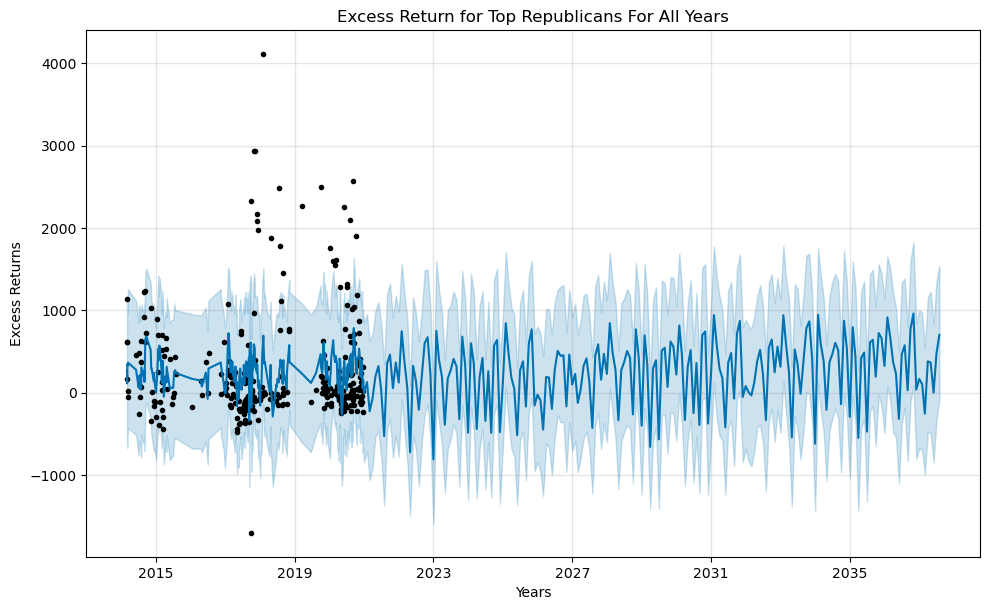

In [85]:
fig = r_model.plot(r_forecast)
plt.ylabel('Excess Returns')
plt.xlabel('Years')
plt.title('Excess Return for Top Republicans For All Years')
plt.show()


## Plot the forecast for the top Democrats

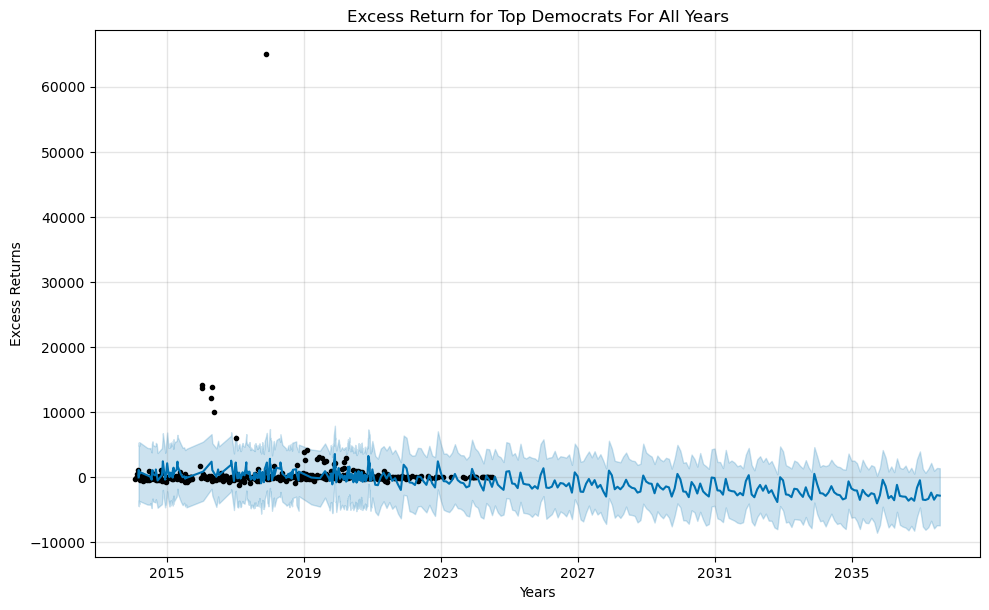

In [45]:
fig = d_model.plot(d_forecast)
plt.ylabel('Excess Returns')
plt.xlabel('Years')
plt.title('Excess Return for Top Democrats For All Years')
plt.show()

## Plot the forecast for the top performer

In [46]:
deb = top_politicians_df[top_politicians_df['Name_Party'] == 'Debbie Wasserman Schultz (D)']
deb_prophet = deb.rename(columns={'Traded' : 'ds', 'excess_return' : 'y'})

# sum the excess return for the datess
deb_prophet = deb_prophet.groupby('ds').agg({'y': 'sum'}).reset_index()

# Drop an NaN values from the prophet_df DataFrame
deb_prophet = deb_prophet.dropna()

# # View the first and last five rows of the mercado_prophet_df DataFrame
display(deb_prophet.head())

,ds,y
0,2014-10-09,139.48
1,2014-10-29,1073.76
2,2014-11-04,641.28
3,2015-02-17,129.18
4,2015-02-23,65.54


In [47]:
deb_model = Prophet()
deb_model.fit(deb_prophet)
deb_future = deb_model.make_future_dataframe(periods=250, freq='M')
deb_forecast = deb_model.predict(r_future)

19:16:29 - cmdstanpy - INFO - Chain [1] start processing
19:16:30 - cmdstanpy - INFO - Chain [1] done processing
/Users/trevor/anaconda3/envs/dev/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


/Users/trevor/anaconda3/envs/dev/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/trevor/anaconda3/envs/dev/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


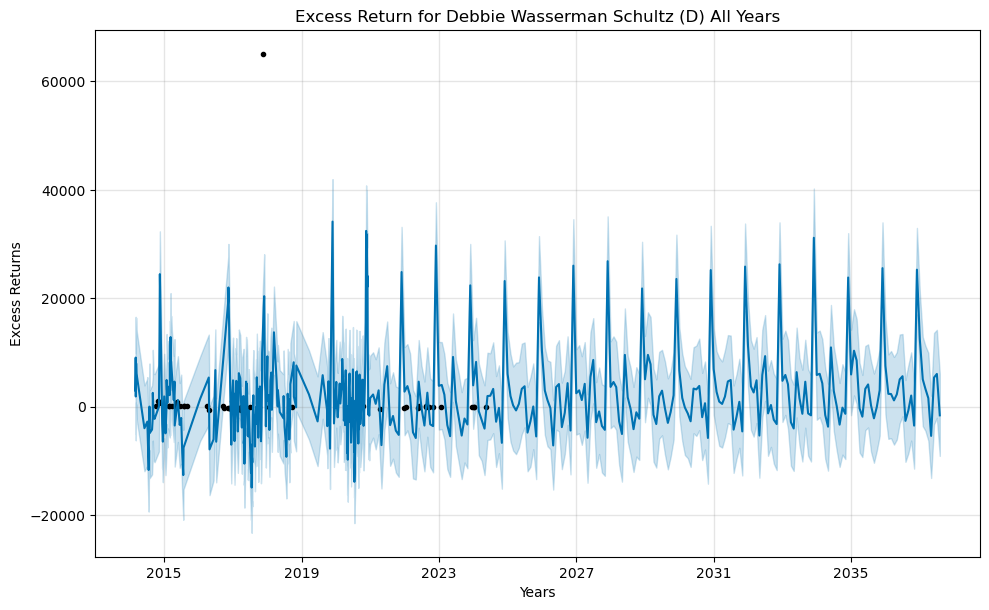

In [48]:
fig = deb_model.plot(deb_forecast)
plt.ylabel('Excess Returns')
plt.xlabel('Years')
plt.title('Excess Return for Debbie Wasserman Schultz (D) All Years')
plt.show()

## Future Prediction Findings

**Question:** What do the future predictions indicate about the excess returns of the Republicans?

**Answer:** The future predictions indicate that there will be a gradual rise over the years of the excess return for the top performing Republicans, with highs and lows over the years as it increases.

**Question:** What do the future predictions indicate about the excess returns of the Democrats?

**Answer:** The future predictions indicate that there will be a gradual rise over the years of the excess return for the top performing Democrats, with highs and lows over the years as it increases.

**Question:** What do the future predictions indicate about the excess returns of Debbie Wasserman Schultz (D)?

**Answer:** The future predictions indicate that there will be a gradual rise over the years of the excess return for Debbie Wasserman Schultz (D), with highs and lows over the years as it increases.

**Question:** Can someone accurately predict when to buy and sell stocks based on the forecasts?

**Answer:** Based on the forecasts it looks like there are consistent highs and lows each year. A buyer might not be able to anticipate exactly when to buy and sell, but they can anticipate market fluctions and invest accordingly.

## Healthcare Market From 2019-2021

In [86]:
df_r = [df_thomas, df_perdue, df_greg]
combined_rep_df = pd.concat(df_r, axis=0)
display(combined_rep_df.head())

df_d = [df_josh, df_lois, df_susie]
combined_dem_df = pd.concat(df_d, axis=0)
display(combined_dem_df.head())

,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party
21206,Thomas Macarthur,R,"INTERACTIVE BROKERS GROUP, INC.",2019-12-21,Purchase,"$1,001 - $15,000",83.47,Thomas Macarthur (R)
26980,Thomas Macarthur,R,PHILIP MORRIS INTERNATIONAL INC,2018-12-31,Sale,"$1,001 - $15,000",-47.91,Thomas Macarthur (R)
26990,Thomas Macarthur,R,NXP SEMICONDUCTORS N.V.,2018-12-31,Purchase,"$15,001 - $50,000",128.38,Thomas Macarthur (R)
26997,Thomas Macarthur,R,VANGUARD FTSE DEVELOPED MARKETS ETF,2018-12-28,Purchase,"$1,001 - $15,000",-83.91,Thomas Macarthur (R)
26999,Thomas Macarthur,R,VANGUARD FTSE DEVELOPED MARKETS ETF,2018-12-28,Purchase,"$1,001 - $15,000",-83.91,Thomas Macarthur (R)


,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party
24,Josh Gottheimer,D,MARRIOTT INTERNATIONAL - CLASS A COMMON STOCK,2024-06-28,Sale,"$1,001 - $15,000",-2.18,Josh Gottheimer (D)
25,Josh Gottheimer,D,APPLE INC. - COMMON STOCK,2024-06-28,Purchase,"$1,001 - $15,000",3.44,Josh Gottheimer (D)
27,Josh Gottheimer,D,NVIDIA CORPORATION - COMMON STOCK,2024-06-28,Purchase,"$1,001 - $15,000",-8.52,Josh Gottheimer (D)
28,Josh Gottheimer,D,MICROSOFT CORPORATION - COMMON STOCK,2024-06-28,Purchase,"$1,001 - $15,000",-4.89,Josh Gottheimer (D)
30,Josh Gottheimer,D,"LOWE'S COMPANIES, INC. COMMON STOCK",2024-06-28,Sale,"$1,001 - $15,000",8.31,Josh Gottheimer (D)


## Sort by excess returns

In [87]:
sorted_rep_df = combined_rep_df.sort_values('excess_return', ascending=False)
display(sorted_rep_df.head())

sorted_dem_df = combined_dem_df.sort_values('excess_return', ascending=False)
display(sorted_dem_df.head())

,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party
17879,"Perdue, David",R,Targa Resources Corp.,2020-04-15,Sale (Full),"$1,001 - $15,000",1450.66,"Perdue, David (R)"
36047,Thomas Macarthur,R,"IMMUNOGEN, INC.",2016-12-08,Sale,"$1,001 - $15,000",1429.56,Thomas Macarthur (R)
22613,Greg Gianforte,R,"CBL & ASSOCIATES PROPERTIES, INC.",2019-09-11,Sale,"$15,001 - $50,000",1371.28,Greg Gianforte (R)
27279,Greg Gianforte,R,"CBL & ASSOCIATES PROPERTIES, INC.",2018-12-21,Purchase,"$50,001 - $100,000",1079.24,Greg Gianforte (R)
43194,Thomas Macarthur,R,"MERCADOLIBRE, INC.",2015-02-06,Purchase,"$1,001 - $15,000",1044.32,Thomas Macarthur (R)


,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party
34010,Josh Gottheimer,D,NVIDIA CORPORATION,2017-06-09,Sale,"$1,001 - $15,000",2799.13,Josh Gottheimer (D)
31571,Josh Gottheimer,D,NVIDIA CORPORATION,2018-01-03,Sale,"$1,001 - $15,000",1927.18,Josh Gottheimer (D)
31552,Josh Gottheimer,D,NVIDIA CORPORATION,2018-01-04,Sale,"$1,001 - $15,000",1916.90,Josh Gottheimer (D)
31493,Josh Gottheimer,D,NVIDIA CORPORATION,2018-01-08,Sale,"$1,001 - $15,000",1838.39,Josh Gottheimer (D)
19818,Josh Gottheimer,D,NVIDIA CORPORATION,2020-02-28,Purchase,"$1,001 - $15,000",1490.40,Josh Gottheimer (D)


## Select Trades For Healthcare companies for Democrats and Republicans

In [91]:
# Filter for healthcare companies using .loc
healthcare_rep_df = sorted_rep_df.loc[sorted_rep_df['Company'].str.contains('Healthcare', case=False, na=False)].copy()

# Convert 'Traded' column to datetime if not already
healthcare_rep_df['Traded'] = pd.to_datetime(healthcare_rep_df['Traded'])

# Extract year from 'Traded' column
healthcare_rep_df['Year'] = healthcare_rep_df['Traded'].dt.year

# Filter for healthcare companies using .loc
healthcare_dem_df = sorted_dem_df.loc[sorted_dem_df['Company'].str.contains('Healthcare', case=False, na=False)].copy()

# Convert 'Traded' column to datetime if not already
healthcare_dem_df['Traded'] = pd.to_datetime(healthcare_dem_df['Traded'])

# Extract year from 'Traded' column
healthcare_dem_df['Year'] = healthcare_dem_df['Traded'].dt.year

display(healthcare_rep_df.head())
display(healthcare_dem_df.head())

,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party,Year
18034,"Perdue, David",R,"HCA Healthcare, Inc.",2020-04-14,Sale (Full),"$15,001 - $50,000",123.49,"Perdue, David (R)",2020
31094,Greg Gianforte,R,"HEALTHCARE TRUST OF AMERICA, INC. CLASS A",2018-02-06,Sale,"$1,001 - $15,000",-35.10,Greg Gianforte (R),2018
15530,Greg Gianforte,R,AMN HEALTHCARE SERVICES INC AMN HEALTHCARE SER...,2020-08-31,Purchase,"$15,001 - $50,000",-38.36,Greg Gianforte (R),2020
15468,Greg Gianforte,R,AMN HEALTHCARE SERVICES INC AMN HEALTHCARE SER...,2020-09-02,Purchase,"$1,001 - $15,000",-39.39,Greg Gianforte (R),2020
15467,Greg Gianforte,R,AMN HEALTHCARE SERVICES INC AMN HEALTHCARE SER...,2020-09-02,Purchase,"$1,001 - $15,000",-39.39,Greg Gianforte (R),2020


,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party,Year
18361,Susie Lee,D,"HCA HEALTHCARE, INC.",2020-04-03,Sale,"$1,001 - $15,000",214.13,Susie Lee (D),2020
18169,Susie Lee,D,"HCA HEALTHCARE, INC.",2020-04-07,Sale,"$1,001 - $15,000",154.44,Susie Lee (D),2020
22694,Susie Lee,D,CHANGE HEALTHCARE INC.,2019-09-10,Purchase,"$1,001 - $15,000",119.17,Susie Lee (D),2019
14248,Josh Gottheimer,D,"HCA HEALTHCARE, INC.",2020-11-16,Purchase,"$1,001 - $15,000",83.44,Josh Gottheimer (D),2020
23314,Susie Lee,D,CHANGE HEALTHCARE INC.,2019-07-19,Sale,"$1,001 - $15,000",83.35,Susie Lee (D),2019


## Top Healthcare Company Trades From 2019 - 2021

In [94]:
healthcare_rep_df['Trade_Size_USD'] = healthcare_rep_df['Trade_Size_USD'].fillna(0).round(2)
healthcare_dem_df['Trade_Size_USD'] = healthcare_rep_df['Trade_Size_USD'].fillna(0).round(2)
filtered_healthcare_df = healthcare_rep_df[(healthcare_rep_df['Year'] >= 2019) & (healthcare_rep_df['Year'] <= 2021)]
filtered_healthcare_df_dem = healthcare_dem_df[(healthcare_dem_df['Year'] >= 2019) & (healthcare_dem_df['Year'] <= 2021)]

display(filtered_healthcare_df.head())
display(filtered_healthcare_df_dem.head())

,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party,Year
18034,"Perdue, David",R,"HCA Healthcare, Inc.",2020-04-14,Sale (Full),0.0,123.49,"Perdue, David (R)",2020
15530,Greg Gianforte,R,AMN HEALTHCARE SERVICES INC AMN HEALTHCARE SER...,2020-08-31,Purchase,0.0,-38.36,Greg Gianforte (R),2020
15468,Greg Gianforte,R,AMN HEALTHCARE SERVICES INC AMN HEALTHCARE SER...,2020-09-02,Purchase,0.0,-39.39,Greg Gianforte (R),2020
15467,Greg Gianforte,R,AMN HEALTHCARE SERVICES INC AMN HEALTHCARE SER...,2020-09-02,Purchase,0.0,-39.39,Greg Gianforte (R),2020
15490,Greg Gianforte,R,AMN HEALTHCARE SERVICES INC AMN HEALTHCARE SER...,2020-09-02,Purchase,0.0,-39.39,Greg Gianforte (R),2020


,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party,Year
18361,Susie Lee,D,"HCA HEALTHCARE, INC.",2020-04-03,Sale,NaN,214.13,Susie Lee (D),2020
18169,Susie Lee,D,"HCA HEALTHCARE, INC.",2020-04-07,Sale,NaN,154.44,Susie Lee (D),2020
22694,Susie Lee,D,CHANGE HEALTHCARE INC.,2019-09-10,Purchase,NaN,119.17,Susie Lee (D),2019
14248,Josh Gottheimer,D,"HCA HEALTHCARE, INC.",2020-11-16,Purchase,NaN,83.44,Josh Gottheimer (D),2020
23314,Susie Lee,D,CHANGE HEALTHCARE INC.,2019-07-19,Sale,NaN,83.35,Susie Lee (D),2019


## Combine the top healthcare companies for both parties

In [96]:
## pull the highest excess_return
## print results
combined_df = pd.concat([filtered_healthcare_df, filtered_healthcare_df_dem])

# Ensure excess_return is numeric
combined_df['excess_return'] = pd.to_numeric(combined_df['excess_return'])

# Find the row with the highest excess_return
max_excess_return = combined_df['excess_return'].max()

# Filter out the row with the highest excess_return
filtered_df = combined_df[combined_df['excess_return'] != max_excess_return]

# Display the filtered DataFrame
display(filtered_df.head())

,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party,Year
18034,"Perdue, David",R,"HCA Healthcare, Inc.",2020-04-14,Sale (Full),0.0,123.49,"Perdue, David (R)",2020
15530,Greg Gianforte,R,AMN HEALTHCARE SERVICES INC AMN HEALTHCARE SER...,2020-08-31,Purchase,0.0,-38.36,Greg Gianforte (R),2020
15468,Greg Gianforte,R,AMN HEALTHCARE SERVICES INC AMN HEALTHCARE SER...,2020-09-02,Purchase,0.0,-39.39,Greg Gianforte (R),2020
15467,Greg Gianforte,R,AMN HEALTHCARE SERVICES INC AMN HEALTHCARE SER...,2020-09-02,Purchase,0.0,-39.39,Greg Gianforte (R),2020
15490,Greg Gianforte,R,AMN HEALTHCARE SERVICES INC AMN HEALTHCARE SER...,2020-09-02,Purchase,0.0,-39.39,Greg Gianforte (R),2020


## Top stock sells for healthcare companies

In [97]:
sales_df = combined_df[combined_df['Transaction'] == 'Sale']
display(sales_df)

,Name,Party,Company,Traded,Transaction,Trade_Size_USD,excess_return,Name_Party,Year
22668,Greg Gianforte,R,"HEALTHCARE SERVICES GROUP, INC.",2019-09-10,Sale,0.0,-135.90,Greg Gianforte (R),2019
18361,Susie Lee,D,"HCA HEALTHCARE, INC.",2020-04-03,Sale,NaN,214.13,Susie Lee (D),2020
18169,Susie Lee,D,"HCA HEALTHCARE, INC.",2020-04-07,Sale,NaN,154.44,Susie Lee (D),2020
23314,Susie Lee,D,CHANGE HEALTHCARE INC.,2019-07-19,Sale,NaN,83.35,Susie Lee (D),2019
13580,Josh Gottheimer,D,"HCA HEALTHCARE, INC.",2021-01-04,Sale,NaN,69.23,Josh Gottheimer (D),2021
12887,Susie Lee,D,"HCA HEALTHCARE, INC.",2021-02-09,Sale,NaN,62.79,Susie Lee (D),2021
13536,Susie Lee,D,CHANGE HEALTHCARE INC.,2021-01-06,Sale,NaN,20.27,Susie Lee (D),2021
